In [4]:
#%matplotlib inline

In [23]:
import scipy.integrate as integrate
import numpy as np
import numpy.random as rd
from fractions import Fraction
import scipy.interpolate as interpolate
import scipy.optimize as optimize
import scipy as sp
import time
import configparser
from sys import argv
import diagonalisation
import eoms
import output
import plot
import sys
from sys import argv
import model_class
import strash

In [24]:
from neurodiffeq.neurodiffeq import diff # the differentiation operation
from neurodiffeq.solvers import Solver1D, Solver2D
from neurodiffeq.conditions import IVP, DirichletBVP2D # the initial condition
import neurodiffeq.networks
from neurodiffeq.networks import FCNN, SinActv

In [25]:
import torch
import matplotlib.pyplot as plt
from neurodiffeq import diff
from neurodiffeq.conditions import IVP
from neurodiffeq.networks import FCNN
from neurodiffeq.solvers import Solver1D
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.callbacks import MonitorCallback
from neurodiffeq.conditions import DirichletBVP2D
from neurodiffeq.solvers import Solver2D
from neurodiffeq.monitors import Monitor2D
from neurodiffeq.generators import Generator2D
from neurodiffeq.conditions import IBVP1D
from neurodiffeq.pde import make_animation
import torch
import numpy as np
import matplotlib.pyplot as plt

In [62]:
!python3 strash.py con_trash.ini

mo, c, n, N, n_cross, a0, sa, b0, sb, s1, s2, phi_range, phidotin, ain, tin, tfi, rhocrit, rho_m0, rho_r0, rhol
[3, 1.0, 1, 1000, 2, 1.0, 0.1, 1.0, 0.1, 0.1, 1.5, 3.141592653589793, 0.0, 1e-08, 0.0, 1.0, 3.0, 0.81, 0.00027138, 2.19]
[[ 2.54754728e+00  0.00000000e+00  4.64812247e-01  1.00000000e-08]
 [ 2.54754721e+00 -1.24362022e-04  4.64812231e-01  8.73402274e-03]
 [ 2.54754703e+00 -2.47118497e-04  4.64812186e-01  1.37259372e-02]
 ...
 [ 2.49404329e+00 -9.52325773e-02  4.50027773e-01  1.04062389e+00]
 [ 2.49394793e+00 -9.52875246e-02  4.49998943e-01  1.04172652e+00]
 [ 2.49385252e+00 -9.53423877e-02  4.49970089e-01  1.04282994e+00]]


In [53]:
mo = 3
c =  1.0
n =  1
N =  1000
n_cross = 2 
a0 = 1.0
sa = 0.1 
b0 =  1.0
sb =  0.1
s1 =  0.1
s2 = 1.5
phi_range = np.pi  
phidotin = 0 
ain = 0.00000001
tin = 0
tfi = 1
rhocrit = 3.0 
rho_m0 = 0.81 
rho_r0 = 0.00027138 
rho_l = 2.19
mpl = 2.435e27

t = np.linspace(tin, tfi, N)

In [54]:
def diag(mo,c,n,a0,b0,sa,sb,s1,s2,phi_range,phidotin):
	if mo == 3:

        ######################################
		####          Kahler              ####
		######################################

		k = (a0/np.random.uniform(s1,s2,(n,n))) #random matrix k from log normal distribution
		kT = k.transpose() # transpose of random matrix k
		k2 = np.dot(k,kT)  # Construction of symmeterised Kahler matric for real axion fields
		ev,pT = np.linalg.eigh(k2) # calculation of eigen values and eigen vectors
		fef = np.sqrt(ev)
		p = pT.transpose() # tranpose of rotational matrix constructed of eigen vectors
		kD = reduce(np.dot, [p, k2, pT]) #diagonalisation of Kahler metric
		kD[kD < 1*10**-13] = 0 # removal of computational error terms in off diagonal elements
		kDr = np.zeros((n, n))#creation of empty 3x3 matrix
		np.fill_diagonal(kDr, (1/((2**0.5)*np.sqrt(ev))))# matrix for absolving eigen values of kahler metric into axion fields
		#kDr[kDr > 1*10**23] = 0 # remove computational errors in reciprocal matrix
		kDrT = kDr.transpose() # trasnpose of kDr matrix

		######################################
		####            Mass              ####
		######################################

		m = (np.random.uniform(np.log(b0)-sb,np.log(b0)+sb,(n,n))) #random matrix m from log normal distribution
		mm = np.exp(-m)
		mT = mm.transpose() # transpose of random matrix m
		m2 = np.dot(mm,mT) # symmeterised mass matrix from real axion fields
		mn = reduce(np.dot, [pT,kDrT, m2, kDr,p]) # correct mass matrix caclulation
		ma_array,mv = np.linalg.eigh(mn) # reout of masses from eigenvalues of mn


	phiin_array = rd.uniform(-phi_range,phi_range,n)

	for i in range (0,n):
		phiin_array[i] = phiin_array[i]*fef[i]
	phiin_array=np.dot(mv,phiin_array)

	phidotin_array = [phidotin]*n #### array of phidotin where all are set equal to zero

	####################################################################
	####################################################################

		
	return ma_array,fef,phiin_array,phidotin_array

In [55]:
def rhoinitial(phidotin_array,phiin_array,ma_array,n):
	rhoin_array=[]
	for i in range(n):	
		rhoin_array.append( 0.5*phidotin_array[i]**2 + 0.5*(ma_array[i]**2)*phiin_array[i]**2 )
	return rhoin_array
	
###################################################################	

###################################################################
####                    Initial y array                        ####
###################################################################
	
def yinitial(n,phiin_array,phidotin_array,rhoin_array,ain):
	y0=[]
	for i in range(n):
		y0.append(phiin_array[i])
		y0.append(phidotin_array[i])
		y0.append(rhoin_array[i])
	y0.append(ain)
#	print(y0)
	return y0	

def deriv_rho(y,t,n,ma_array,rho_m0,rho_r0,rhol): 
	func=[]
	rho_ax=sum(y[:-1])
	for i in range(n):
		if np.sqrt(3)*np.sqrt(rho_ax + rho_m0/y[-1]**3 + rho_r0/y[-1]**4 + rhol) > 2*(ma_array[i]):
			func.append((-3/np.sqrt(3)*np.sqrt(rho_ax + rho_m0/y[-1]**3 + rho_r0/y[-1]**4 + rhol)*(1-1)*(y[i])))
		else:
			func.append((-3/np.sqrt(3)*np.sqrt(rho_ax + rho_m0/y[-1]**3 + rho_r0/y[-1]**4 + rhol)*(y[i])))	
	func.append((1/np.sqrt(3)*np.sqrt(rho_ax*y[-1]**2 + rho_m0/y[-1] + rho_r0/y[-1]**2 + rhol*y[-1]**2)))
	return func

#def deriv_wfromphi(vars, t, n, n_cross, ma_array, rho_m0, rho_r0, rhol):
#    crossing_index = [0]*n
#    func = []
#    rho_ax = sum(vars[2::3])  # ใช้ vars แทน y ในการเข้าถึงค่าตัวแปร
#
#    for i in range(n):
#        if (crossing_index[i] % 2 == 0 and ma_array[i] * vars[3*i] * vars[3*i] < vars[3*i+1] * vars[3*i+1] and vars[3*i+1] > 0) or \
#           (crossing_index[i] % 2 == 1 and ma_array[i] * vars[3*i] * vars[3*i] > vars[3*i+1] * vars[3*i+1] and vars[3*i+1] < 0):
#            crossing_index[i] += 1
#        
#        func.append(vars[3*i+1])  # ใช้ vars แทน y ในการเข้าถึงค่าตัวแปร
#        if crossing_index[i] < n_cross:
#            func.append(-np.sqrt(3) * (np.sqrt(rho_ax + rho_m0 / vars[-1]**3 + rho_r0 / vars[-1]**4 + rhol)) * vars[3*i+1] - (ma_array[i]**2) * vars[3*i])
#        else:
#            func.append(-np.sqrt(3) * (np.sqrt(rho_ax + rho_m0 / vars[-1]**3 + rho_r0 / vars[-1]**4 + rhol)) * vars[3*i+1])
#        
#        if crossing_index[i] < n_cross:
#            func.append(-3 / np.sqrt(3) * np.sqrt(rho_ax + rho_m0 / vars[-1]**3 + rho_r0 / vars[-1]**4 + rhol) * vars[3*i+1]**2)
#        else:
#            func.append(-3 / np.sqrt(3) * np.sqrt(rho_ax + rho_m0 / vars[-1]**3 + rho_r0 / vars[-1]**4 + rhol) * vars[3*i+2])
#
#    func.append((1 / np.sqrt(3) * np.sqrt(rho_ax * (vars[-1])**2 + rho_m0 / vars[-1] + rho_r0 / vars[-1]**2 + rhol * (vars[-1])**2)))
#
#    print(crossing_index)
#
#    return func

#def deriv_wfromphi(y, t, n, n_cross, ma_array, rho_m0, rho_r0, rhol):
#def deriv_wfromphi(y, ma_array):
#
#    crossing_index = [0]*n
#    func = []
#    rho_ax = sum(y[2::3])  # ใช้ y แทน y ในการเข้าถึงค่าตัวแปร
#
#    for i in range(n):
#        if (crossing_index[i] % 2 == 0 and ma_array[i] * y[3*i] * y[3*i] < y[3*i+1] * y[3*i+1] and y[3*i+1] > 0) or \
#           (crossing_index[i] % 2 == 1 and ma_array[i] * y[3*i] * y[3*i] > y[3*i+1] * y[3*i+1] and y[3*i+1] < 0):
#            crossing_index[i] += 1
#        
#        func.append(y[3*i+1])  # ใช้ y แทน y ในการเข้าถึงค่าตัวแปร
#        if crossing_index[i] < n_cross:
#            func.append((-np.sqrt(3) * (np.sqrt(rho_ax + rho_m0 / y[-1]**3 + rho_r0 / y[-1]**4 + rhol)) * y[3*i+1] - (ma_array[i]**2) * y[3*i]))
#        else:
#            func.append(-np.sqrt(3) * (np.sqrt(rho_ax + rho_m0 / y[-1]**3 + rho_r0 / y[-1]**4 + rhol)) * y[3*i+1])
#        
#        if crossing_index[i] < n_cross:
#            func.append(-3 / np.sqrt(3) * np.sqrt(rho_ax + rho_m0 / y[-1]**3 + rho_r0 / y[-1]**4 + rhol) * y[3*i+1]**2)
#        else:
#            func.append(-3 / np.sqrt(3) * np.sqrt(rho_ax + rho_m0 / y[-1]**3 + rho_r0 / y[-1]**4 + rhol) * y[3*i+2])
#
#    func.append((1 / np.sqrt(3) * np.sqrt(rho_ax * (y[-1])**2 + rho_m0 / y[-1] + rho_r0 / y[-1]**2 + rhol * (y[-1])**2)))
#
#    print(crossing_index)
#
#    return func



In [56]:
ma_array, fef, phiin_array, phidotin_array = diagonalisation.diag(mo, c, n, a0, b0, sa, sb, s1, s2, phi_range, phidotin)
rhoin_array = eoms.rhoinitial(phidotin_array, phiin_array, ma_array, n)
y0 = eoms.yinitial(n, phiin_array, phidotin_array, rhoin_array, ain)

In [57]:
#def eq(y,t):
#    return deriv_wfromphi(y, t, n, n_cross, ma_array, rho_m0, rho_r0, rhol)

In [58]:
y0

[-2.082766611723061, 0, 0.1336279095225289, 1e-08]

In [59]:
#ma_array = np.array([0])

In [60]:
ma = torch.tensor(ma_array/10)
ma

tensor([0.0248])

In [12]:
#deriv_wfromphi(y0, t, n, n_cross, ma_array, rho_m0, rho_r0, rhol)
#deriv_wfromphi(y0, t, ma_array)

update 
งานที่ยังแก้ไขไม่ได้ในตอนนี้ คือ การที่ input ของ deriv_wfromphi คือ 
$$[\phi_1,\dot{\phi_1},\rho_1,\phi_2,\dot{\phi_2},\rho_2,...,\phi_n,\dot{\phi_n},\rho_n,a]$$ 
และ return output ออกมาเป็น
$$[\dot{\phi_1},\ddot{\phi_1},\dot{\rho_1},\dot{\phi_2},\ddot{\phi_2},\dot{\rho_2},...,\dot{\phi_n},\ddot{\phi_n},\dot{\rho_n},\dot{a}]$$
แต่สิ่งที่เราใส่เข้าไปใน neurodiffeq คือมีการใส่ initial conditions ซ้ำทำให้โปรแกรมมันมีการซ้ำและมั่ว หรืออาจจะส่งผลให้ค่ามันแปลกๆ ไม่ทำงาน


สำหรับ input ของ neurodiffeq Solve ที่เราต้องใส่ลงไป จะประกอบไปด้วย
solve(function,condition,tmin,tmax,NN)

แต่ function ที่เรามีตอนนี้คือ deriv_wfromphi input ที่ใส่เข้าไปในนั้นจะเป็น condition เดียวกันกับที่ต้องการใส่ลงไปใน neurodiffeq 

กำหนดให้ \
y[-1] = a \
y[3i] = $\phi$ \
y[3i+1] = $\dot{\phi}$ \
y[3i+2] = $\rho$

In [13]:
initial_conditions = []
nets = []
for i in range(3*n+1):
    nets.append(FCNN(actv=SinActv))
for i in range(n):
    initial_conditions.append(IVP(t_0=0.0, u_0=y0[3*i]))
    initial_conditions.append(IVP(t_0=0.0, u_0=y0[3*i+1]))
    initial_conditions.append(IVP(t_0=0.0, u_0=y0[3*i+2]))
initial_conditions.append(IVP(t_0=0.0, u_0=y0[-1]))

In [14]:
type(initial_conditions)

list

In [15]:
#initial_conditions,nets

In [16]:
#for i in range(n):
#    print(y0[3*i],y0[3*i+1],y0[3*i+2],y0[-1])

In [17]:
#def deriv_wfromphi(y,t, ma_array):
def deriv_wfromphi(y,t):
    crossing_index = [0]*n
    func = []
    rho_ax = sum(y[2::3])  # ใช้ y แทน y ในการเข้าถึงค่าตัวแปร

    for i in range(n):
        if (crossing_index[i] % 2 == 0 and ma_array[i] * y[3*i] * y[3*i] < y[3*i+1] * y[3*i+1] and y[3*i+1] > 0) or \
           (crossing_index[i] % 2 == 1 and ma_array[i] * y[3*i] * y[3*i] > y[3*i+1] * y[3*i+1] and y[3*i+1] < 0):
            crossing_index[i] += 1
        
        func.append(y[3*i+1])  # ใช้ y แทน y ในการเข้าถึงค่าตัวแปร
        if crossing_index[i] < n_cross:
            func.append(diff(y[3*i+1],t)-(-np.sqrt(3) * (np.sqrt(rho_ax + rho_m0 / y[-1]**3 + rho_r0 / y[-1]**4 + rhol)) * y[3*i+1] - (ma_array[i]**2) * y[3*i]))
        else:
            func.append(diff(y[3*i+1],t)-(-np.sqrt(3) * (np.sqrt(rho_ax + rho_m0 / y[-1]**3 + rho_r0 / y[-1]**4 + rhol)) * y[3*i+1]))
        
        if crossing_index[i] < n_cross:
            func.append(diff(y[3*i+2],t)-(-3 / np.sqrt(3) * np.sqrt(rho_ax + rho_m0 / y[-1]**3 + rho_r0 / y[-1]**4 + rhol) * y[3*i+1]**2))
        else:
            func.append(diff(y[3*i+2],t)-(-3 / np.sqrt(3) * np.sqrt(rho_ax + rho_m0 / y[-1]**3 + rho_r0 / y[-1]**4 + rhol) * y[3*i+2]))

    func.append(diff(y[-1],t)-((1 / np.sqrt(3) * np.sqrt(rho_ax * (y[-1])**2 + rho_m0 / y[-1] + rho_r0 / y[-1]**2 + rhol * (y[-1])**2))))

    print(crossing_index)

    return func

In [18]:
#phi = 
#phid = 
#rho = 
a = 1e-8

In [19]:
#
def wfromphi(phi,phid,rho,a,t):
    crossing_index = [0]*n
    func = []
#    rho_ax = sum(y[2::3])  # ใช้ y แทน y ในการเข้าถึงค่าตัวแปร
    rho_ax = rho
#    for i in range(n):
#        if (crossing_index[i] % 2 == 0 and ma_array[i] * phi * phi < phid * phid and phid > 0) or \
#           (crossing_index[i] % 2 == 1 and ma_array[i] * phi * phi > phid * phid and phid < 0):
#            crossing_index[i] += 1
        
    #func.append(phid)  # ใช้ y แทน y ในการเข้าถึงค่าตัวแปร
    func.append(diff(phi,t))
    func.append(diff(phid,t))
    func.append(rho)
    func.append(a)

    #    print(phid)
#    func.append(diff(phid,t)-(-np.sqrt(3) * (torch.sqrt(rho_ax + rho_m0 / a**3 + rho_r0 / a**4 + rhol)) * phid - (torch.from_numpy(ma_array)**2) * phi))
#    print((diff(phid,t)-(-np.sqrt(3) * (torch.sqrt(rho_ax + rho_m0 / a**3 + rho_r0 / a**4 + rhol)) * phid - (torch.from_numpy(ma_array)**2) * phi))
#)
#    func.append(diff(rho,t)-(-3 / np.sqrt(3) * torch.sqrt(rho_ax + rho_m0 / a**3 + rho_r0 / a**4 + rhol) * phid**2))
#    print((diff(rho,t)-(-3 / np.sqrt(3) * torch.sqrt(rho_ax + rho_m0 / a**3 + rho_r0 / a**4 + rhol) * phid**2))
#)    
#    func.append(diff(a,t)-((1 / np.sqrt(3) * torch.sqrt(rho_ax * (a)**2 + rho_m0 / a + rho_r0 / a**2 + rhol * (a)**2))))
#    print((diff(a,t)-((1 / np.sqrt(3) * torch.sqrt(rho_ax * (a)**2 + rho_m0 / a + rho_r0 / a**2 + rhol * (a)**2))))
#)
#    print(crossing_index)
#    print(func)
    return func

In [37]:
# กำหนดเงื่อนไขเริ่มต้น
#initial_conditions = [IVP(t_0=0.0, u_0=1.5), IVP(t_0=0.0, u_0=1.0),]

#nets = [FCNN(actv=SinActv), FCNN(actv=SinActv)]
#ode = lambda *vars,t: deriv_wfromphi(*vars, t, ma_array=ma_array)
#ode = lambda *vars,t: wfromphi(*vars, t)
#ode = lambda t: deriv_wfromphi(t, n=n, n_cross=n_cross, ma_array=ma_array, rho_m0=rho_m0, rho_r0=rho_r0, rhol=rhol)

# สร้าง Solver และแก้สมการ
solver = Solver1D(wfromphi,conditions=initial_conditions,t_min=0.0, t_max=1.0, nets=nets)
solver.fit(max_epochs=10)
solution = solver.get_solution()

# แสดงผลลัพธ์
t = torch.linspace(0, 10, 100)
phi,phid,rho,a = solution(t,to_numpy=True)
   



/home/weerachai/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Training Progress:   0%|                                 | 0/10 [00:00<?, ?it/s]

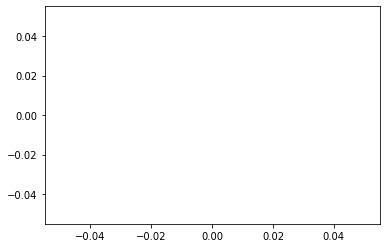

In [90]:
t = np.linspace(0, 10, 100)
plt.plot(t,phi)
#plt.legend()
plt.show()

In [ ]:
n

In [15]:
type(ode)

function

In [137]:
phi

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [15]:
# new version

def ode_system(u,v,w,x,t):
#    return [diff(u,t)-(u*v*w*x), diff(v,t)-(u*v*w*x), diff(w,t)-(u*v*w*x), diff(x,t)-(u*v*w*x)]
    return [diff(u,t), diff(v,t), diff(w,t), diff(x,t)]

#    return [diff(x[0],t)-(x[0]-x[0]*x[1]), diff(x[1],t)-(x[0]*x[0]-x[1])]

conditions = [IVP(t_0=0.0, u_0=1.5), IVP(t_0=0.0, u_0=1.0), IVP(t_0=0.0, u_0=1.5), IVP(t_0=0.0, u_0=2.0)]
nets = [FCNN(actv=SinActv), FCNN(actv=SinActv), FCNN(actv=SinActv), FCNN(actv=SinActv)]


solver = Solver1D(ode_system, conditions, t_min=0.0, t_max=30.0, nets=nets)
solver.fit(max_epochs=2000)
solution = solver.get_solution()

/home/weerachai/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Training Progress:   0%|                               | 0/2000 [00:00<?, ?it/s]

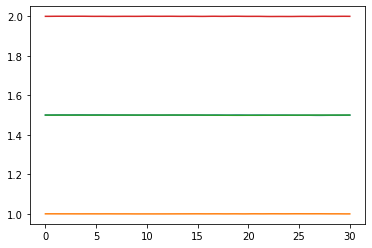

In [16]:
t = np.linspace(0, 30, 100)
u, v, w, x = solution(t, to_numpy=True)  # t can be np.ndarray or torch.Tensor
plt.plot(t,u)
plt.plot(t,v)
plt.plot(t,w)
plt.plot(t,x)
plt.show()

Training Progress:   0%|                               | 0/2000 [00:00<?, ?it/s]

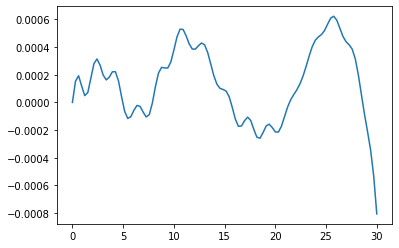

In [29]:
# Eq:1
def ode_system(phi,t):
    return [diff(phi,t,order=2)-diff(phi,t)]

conditions = [IVP(t_0=0.0, u_0=0)]
nets = [FCNN(actv=SinActv)]


solver = Solver1D(ode_system, conditions, t_min=0.0, t_max=30.0, nets=nets)
solver.fit(max_epochs=2000)
solution = solver.get_solution()

t = np.linspace(0, 30, 100)
u = solution(t, to_numpy=True)  # t can be np.ndarray or torch.Tensor
plt.plot(t,u)
plt.show()

Training Progress:   0%|                               | 0/2000 [00:00<?, ?it/s]

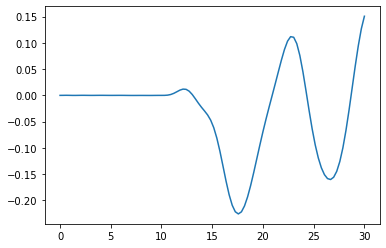

In [33]:
# Eq:2.1
phi = 0.1
a = 1
rho_ax = 1
ma = 1
def ode_system(phi,t):
    return [diff(phi,t,order=2)-(-np.sqrt(3) * (np.sqrt(rho_ax + rho_m0 / a**3 + rho_r0 / a**4 + rhol)) * diff(phi,t) - ma**2*phi)]

#conditions = [IVP(t_0=0.0, u_0=0)]
conditions = [IVP(t_0=0.0, u_0=0,u_0_prime=0)]
nets = [FCNN(actv=SinActv)]


solver = Solver1D(ode_system, conditions, t_min=0.0, t_max=10.0, nets=nets)
solver.fit(max_epochs=2000)
solution = solver.get_solution()

t = np.linspace(0, 30, 100)
u = solution(t, to_numpy=True)  # t can be np.ndarray or torch.Tensor
plt.plot(t,u)
plt.show()

Training Progress:   0%|                               | 0/2000 [00:00<?, ?it/s]

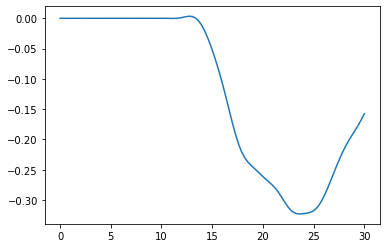

In [35]:
# Eq:2.2
phi = 0.1
a = 1
rho_ax = 1
ma = 1
def ode_system(phi,t):
    return [diff(phi,t,order=2)-(-np.sqrt(3) * (np.sqrt(rho_ax + rho_m0 / a**3 + rho_r0 / a**4 + rhol)) * diff(phi,t))]

#conditions = [IVP(t_0=0.0, u_0=0)]
conditions = [IVP(t_0=0.0, u_0=0,u_0_prime=0)]
nets = [FCNN(actv=SinActv)]


solver = Solver1D(ode_system, conditions, t_min=0.0, t_max=10.0, nets=nets)
solver.fit(max_epochs=2000)
solution = solver.get_solution()

t = np.linspace(0, 30, 100)
u = solution(t, to_numpy=True)  # t can be np.ndarray or torch.Tensor
plt.plot(t,u)
plt.show()

Training Progress:   0%|                               | 0/2000 [00:00<?, ?it/s]

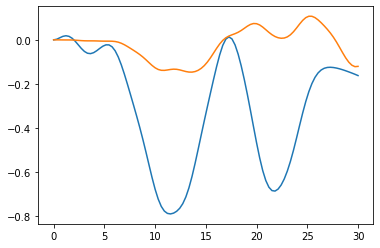

In [37]:
# Eq:3.1
phi = 0.1
a = 1
rho_ax = 1
ma = 1
def ode_system(phi,rho,t):
    return [diff(rho,t)-(-np.sqrt(3)/3 * (np.sqrt(rho_ax + rho_m0 / a**3 + rho_r0 / a**4 + rhol)) * (diff(phi,t))**2)]

#conditions = [IVP(t_0=0.0, u_0=0)]
conditions = [IVP(t_0=0.0, u_0=0,u_0_prime=0),IVP(t_0=0.0, u_0=0,u_0_prime=0)]
nets = [FCNN(actv=SinActv),FCNN(actv=SinActv)]


solver = Solver1D(ode_system, conditions, t_min=0.0, t_max=10.0, nets=nets)
solver.fit(max_epochs=2000)
solution = solver.get_solution()

t = np.linspace(0, 30, 100)
u,v = solution(t, to_numpy=True)  # t can be np.ndarray or torch.Tensor
plt.plot(t,u)
plt.plot(t,v)
plt.show()

Training Progress:   0%|                               | 0/2000 [00:00<?, ?it/s]

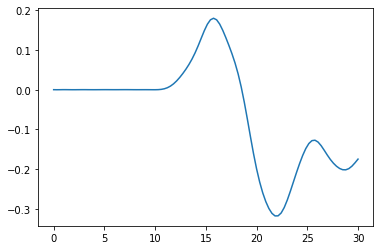

In [55]:
# Eq:3.2
phi = 0.1
a = 1
rho_ax = 1
ma = 1
def ode_system(rho,t):
    return [diff(rho,t)-(-np.sqrt(3)/3 * (np.sqrt(rho_ax + rho_m0 / a**3 + rho_r0 / a**4 + rhol)) * rho)]

#conditions = [IVP(t_0=0.0, u_0=0)]
conditions = [IVP(t_0=0.0, u_0=0,u_0_prime=0)]
nets = [FCNN(actv=SinActv)]


solver = Solver1D(ode_system, conditions, t_min=0.0, t_max=10.0, nets=nets)
solver.fit(max_epochs=2000)
solution = solver.get_solution()

t = np.linspace(0, 30, 100)
u = solution(t, to_numpy=True)  # t can be np.ndarray or torch.Tensor
plt.plot(t,u)
plt.show()

Training Progress:   0%|                               | 0/2000 [00:00<?, ?it/s]

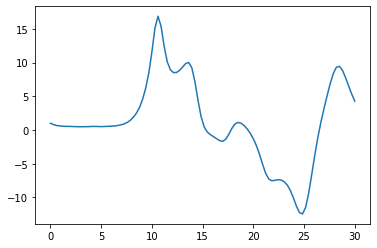

In [71]:
# Eq:4

def ode_system(a,t):
    return [diff(a,t)-(1/np.sqrt(3) * (torch.sqrt(rho_ax*a**2 + rho_m0/a + rho_r0/a**2 + rhol*a**2)))]

#conditions = [IVP(t_0=0.0, u_0=0)]
conditions = [IVP(t_0=0.0, u_0=1, u_0_prime=0)]
nets = [FCNN(actv=SinActv)]


solver = Solver1D(ode_system, conditions, t_min=0.0, t_max=10.0, nets=nets)
solver.fit(max_epochs=2000)
solution = solver.get_solution()

t = np.linspace(0, 30, 100)
u = solution(t, to_numpy=True)  # t can be np.ndarray or torch.Tensor
plt.plot(t,u)
plt.show()

<IPython.core.display.Javascript object>


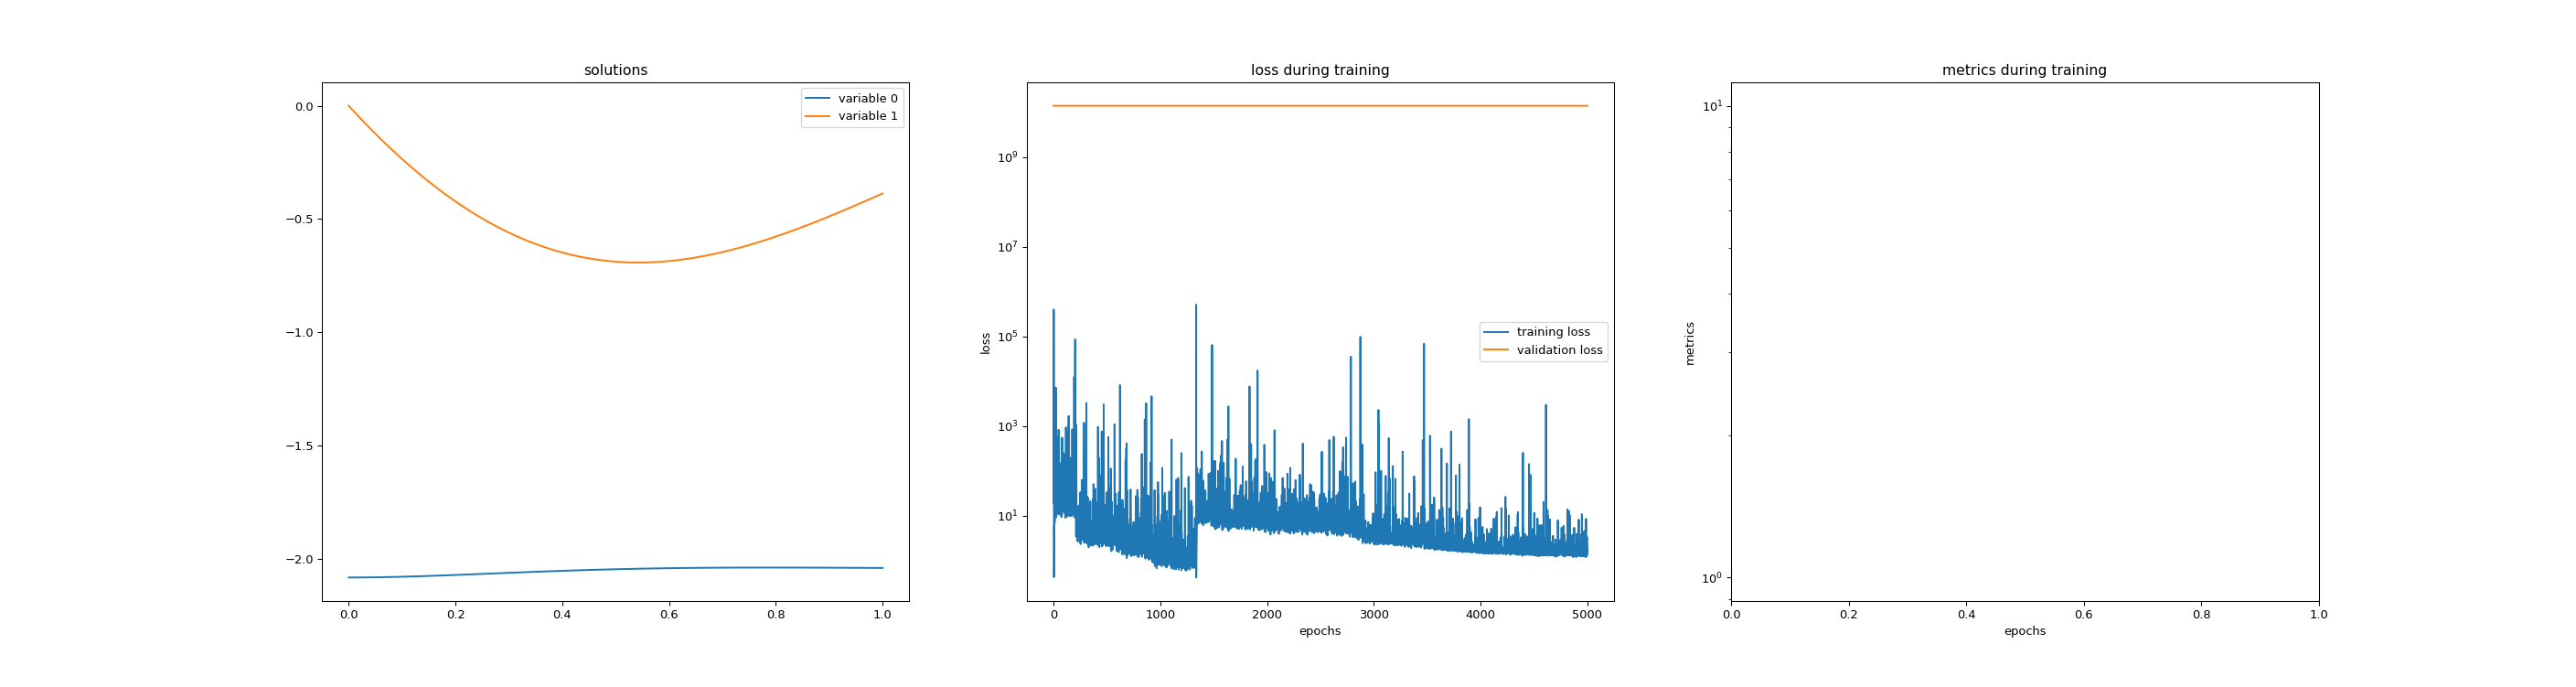

Training Progress:   0%|                               | 0/5000 [00:00<?, ?it/s]

In [76]:
# Eq:
#rho_ax = 1
#ma = 1

def ode_system(phi,a,t):
    phid = diff(phi,t,order=1) 
    phidd = diff(phi,t,order=2) + (np.sqrt(3)*(torch.sqrt(abs( 0.5*phid**2 + 0.5*ma**2*phi**2 + rho_m0*a**(-3) + rho_r0*a**(-4) + rho_l))) * phid + ma**2*phi)
    ad = diff(a,t,order=1) - (1/np.sqrt(3) * (torch.sqrt(abs(0.5*a**2*phid**2 + 0.5*ma**2*a**2*phi**2* + rho_m0*a**(-1) + rho_r0*a**(-2) + rho_l*a**2))))
    return [phidd,ad]


#conditions = [IVP(t_0=0.0, u_0=0)] # a
#conditions = [IVP(t_0=0.0, u_0=1,u_0_prime=0)] # phi
conditions = [IVP(t_0=0.0, u_0=y0[0],u_0_prime=y0[1]),IVP(t_0=0.0, u_0=y0[-1])]
#nets = [FCNN(actv=SinActv)]
nets = [FCNN(actv=SinActv),FCNN(actv=SinActv)]


solver = Solver1D(ode_system, conditions, t_min=0.0, t_max=1.0, nets=nets)
#solver.fit(max_epochs=2000)
#solver.global_epoch
#solver.run_train_epoch()
#solution = solver.get_solution()
#solver.fit(max_epochs=5000)
#solution = solver.get_solution()
#%matplotlib notebook
monitor = Monitor1D(t_min=0.0, t_max=1.0, check_every=200)
solver.fit(max_epochs=5000, callbacks=[monitor.to_callback()])
solution = solver.get_solution()

#t = np.linspace(0, 1, 100)
#u,v = solution(t, to_numpy=True)  # t can be np.ndarray or torch.Tensor
#plt.plot(t,u,color='r')
#plt.plot(t,v,color='b')
#plt.show()

<IPython.core.display.Javascript object>


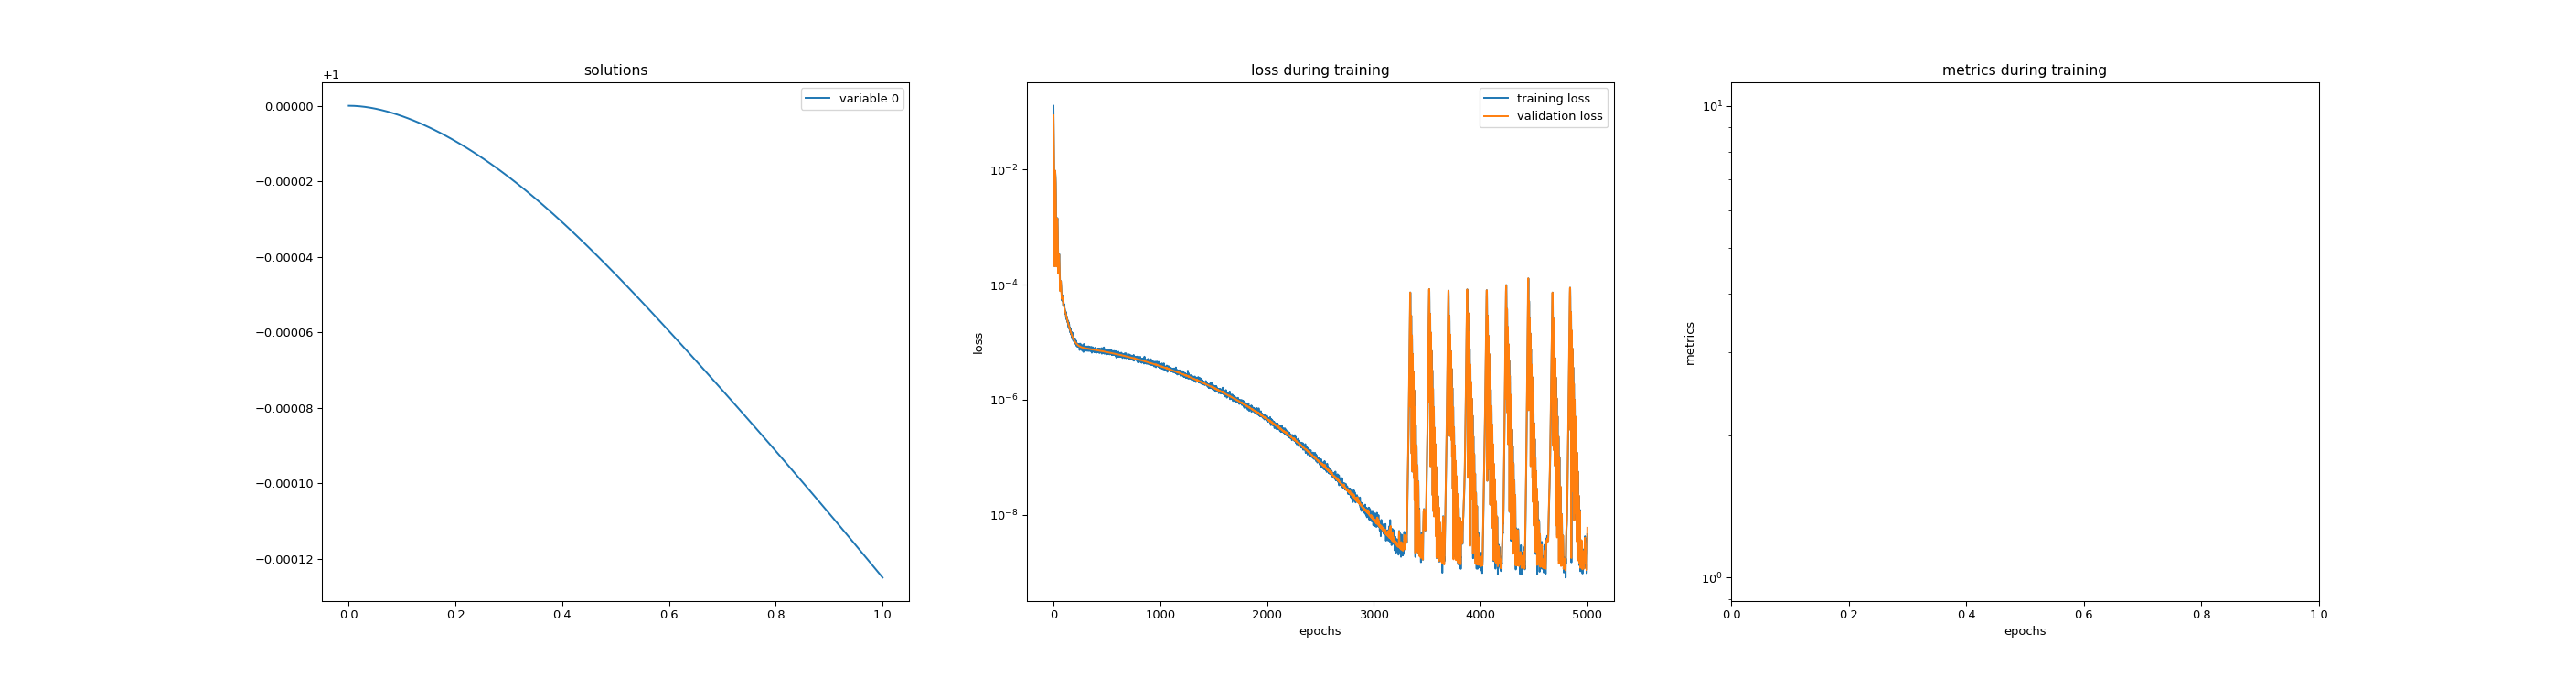

Training Progress:   0%|                               | 0/5000 [00:00<?, ?it/s]

In [73]:
# Eq:
#rho_ax = 1
#ma = 1

def ode_system(phi,t):
    phid = diff(phi,t,order=1) 
    phidd = diff(phi,t,order=2) + (np.sqrt(3)*(torch.sqrt(abs( 0.5*phid**2 + 0.5*ma**2*phi**2 + rho_m0*a**(-3) + rho_r0*a**(-4) + rho_l))) * phid + ma**2*phi)
#    ad = diff(a,t,order=1) - (1/np.sqrt(3) * (torch.sqrt(abs(0.5*a**2*phid**2 + 0.5*ma**2*a**2*phi**2* + rho_m0*a**(-1) + rho_r0*a**(-2) + rho_l*a**2))))
    return [phidd]

#conditions = [IVP(t_0=0.0, u_0=0)] # a
conditions = [IVP(t_0=0.0, u_0=1,u_0_prime=0)] # phi
#conditions = [IVP(t_0=0.0, u_0=y0[0],u_0_prime=y0[1]),IVP(t_0=0.0, u_0=y0[-1])]
nets = [FCNN(actv=SinActv)]
#nets = [FCNN(actv=SinActv),FCNN(actv=SinActv)]


solver = Solver1D(ode_system, conditions, t_min=0.0, t_max=1.0, nets=nets)
#solver.fit(max_epochs=2000)
#solver.global_epoch
#solver.run_train_epoch()
#solution = solver.get_solution()
#solver.fit(max_epochs=5000)
#solution = solver.get_solution()
#%matplotlib notebook
monitor = Monitor1D(t_min=0.0, t_max=1.0, check_every=200)
solver.fit(max_epochs=5000, callbacks=[monitor.to_callback()])
solution = solver.get_solution()

#t = np.linspace(0, 1, 100)
#u,v = solution(t, to_numpy=True)  # t can be np.ndarray or torch.Tensor
#plt.plot(t,u,color='r')
#plt.plot(t,v,color='b')
#plt.show()

In [66]:
t = np.linspace(0, 1, 100)
u,v = solution(t, to_numpy=True)  # t can be np.ndarray or torch.Tensor
plt.plot(t,u,color='r')
plt.plot(t,v,color='b')
plt.show()

In [67]:
# 1
plt.plot(t,v,color='b')
plt.plot(t,u,color='r')

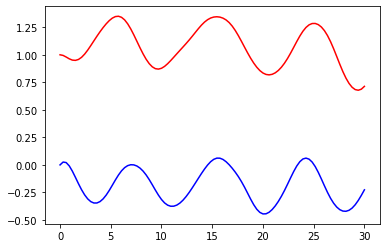

In [32]:
# 2
plt.plot(t,v,color='b')
plt.plot(t,u,color='r')

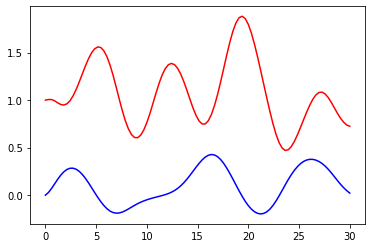

In [34]:
# 3
plt.plot(t,v,color='b')
plt.plot(t,u,color='r')

In [46]:
u,v

(array([1.        , 1.00606937, 1.00601678, 0.9922251 , 0.97129146,
        0.95368917, 0.94838112, 0.96089187, 0.99326458, 1.04469313,
        1.11218163, 1.19106563, 1.27547836, 1.35887241, 1.43461438,
        1.49656446, 1.53951023, 1.55937721, 1.55327213, 1.51954459,
        1.45806626, 1.37076383, 1.26216591, 1.13952788, 1.01218618,
        0.89018988, 0.78270413, 0.69682661, 0.63718362, 0.60620318,
        0.60464366, 0.63195476, 0.68627849, 0.76416838, 0.86028246,
        0.96735679, 1.07668833, 1.17914631, 1.26644962, 1.3322569 ,
        1.37268259, 1.38616958, 1.37299386, 1.33480405, 1.2744521 ,
        1.19610963, 1.10547431, 1.009818  , 0.91767446, 0.83808233,
        0.77948628, 0.74859303, 0.74953982, 0.78359038, 0.84932847,
        0.94314621, 1.05979373, 1.1928091 , 1.33473439, 1.47716342,
        1.61084954, 1.72618218, 1.81416525, 1.86767368, 1.88252994,
        1.85803755, 1.79689303, 1.70457699, 1.58832864, 1.45584304,
        1.31403503, 1.16840052, 1.02334206, 0.88

In [19]:
#ode_system(torch.from_numpy(u),torch.from_numpy(v),t)

$$ \ddot{\phi}_a + \frac{\sqrt{3}}{m_{pl}}\left( \sqrt{\frac{1}{2} \dot{\phi}_a^2 + \frac{1}{2}m^2_a\phi_a^2 + \frac{\rho_{m,0}}{a^3} + \frac{\rho_{r,0}}{a^4} +\rho_{\lambda}}\right)\dot{\phi}_a + m^2_a\phi_a = 0 $$
rewrite the eq.
$$\ddot{\phi}_a + \sqrt{3}\left( \sqrt{\frac{1}{2} \dot{\phi}_a^2 + \frac{1}{2}\phi_a^2} \right)\dot{\phi}_a + \phi_a = 0 $$
where \
$ m_{pl} = m_a = \rho_m = \rho_r = \rho_{\lambda} = a = 1 $

<IPython.core.display.Javascript object>


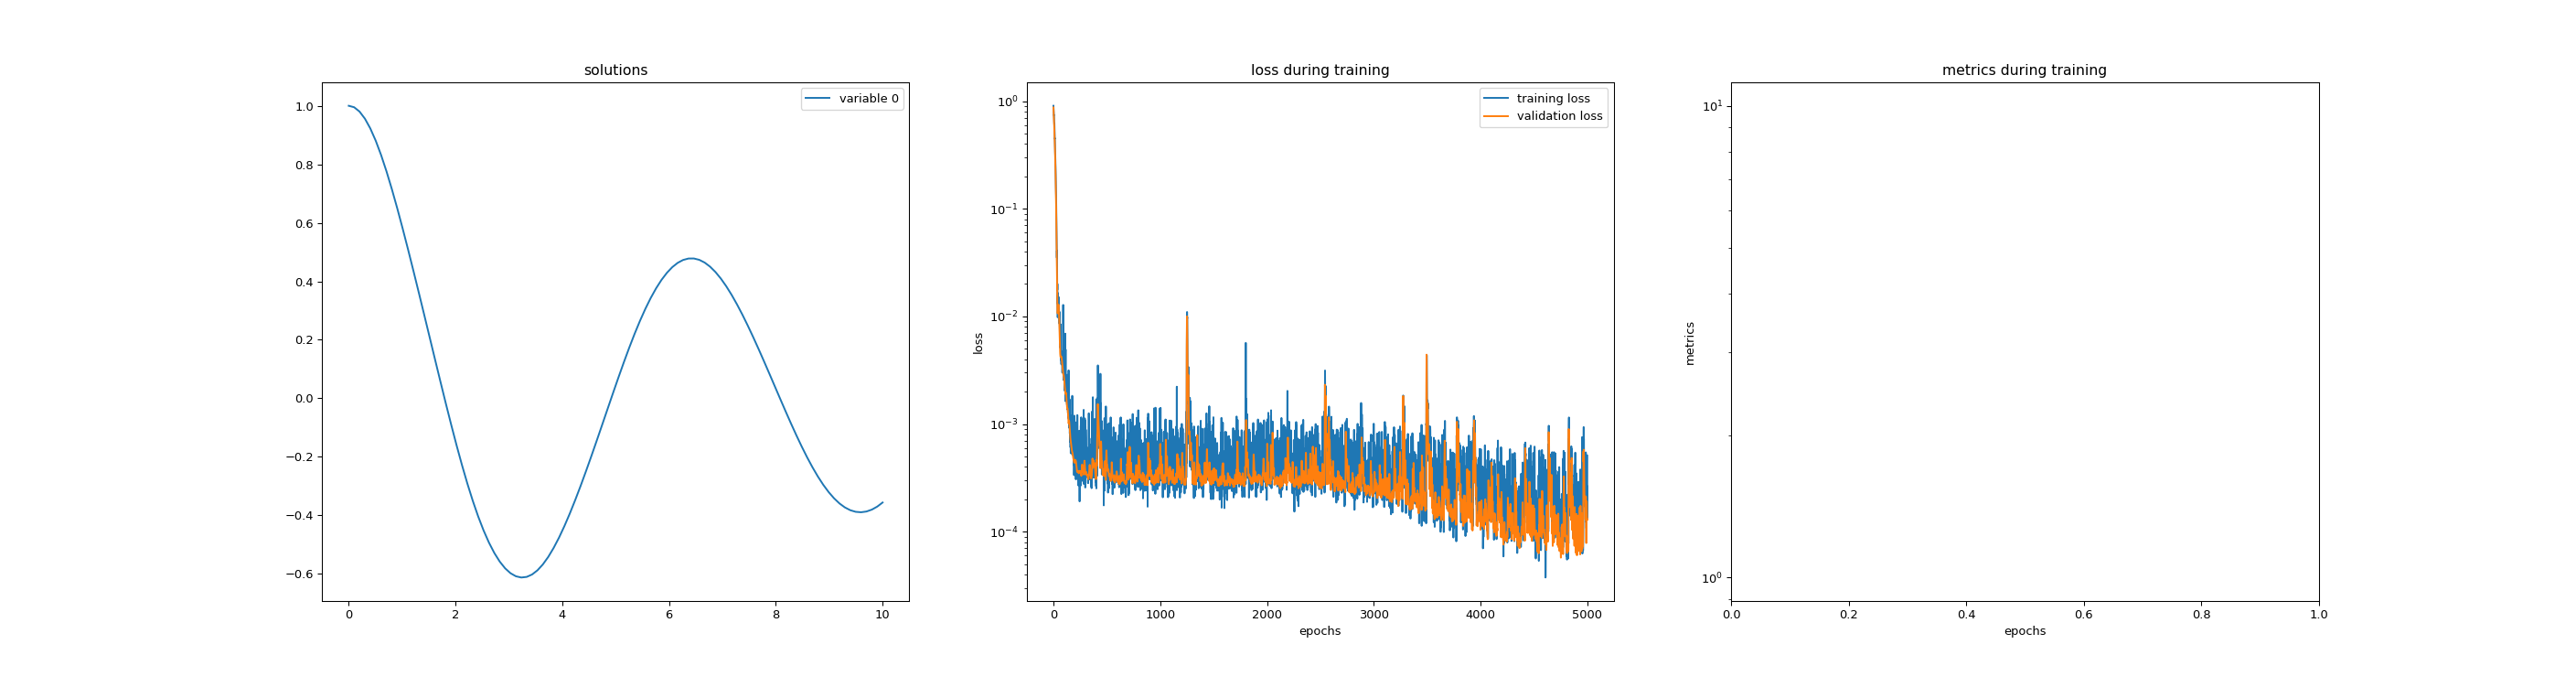

Training Progress:   0%|                               | 0/5000 [00:00<?, ?it/s]

In [34]:
# Eq:
#rho_ax = 1
#ma = 1
#a = 1

#def ode_system(phi,a,t):
#    phid = diff(phi,t,order=1) 
#    phidd = diff(phi,t,order=2) + (np.sqrt(3)*(torch.sqrt(abs(rho_ax + rho_m0 / a**3 + rho_r0 / a**4 + rhol))) * phid + ma**2*phi)
#    ad = diff(a,t,order=1) - (1/np.sqrt(3) * (torch.sqrt(abs(rho_ax*a**2 + rho_m0/a + rho_r0/a**2 + rhol*a**2))))
#    return [phidd,ad]

def ode_system(phi,t):
    phid = diff(phi,t,order=1) 
    phidd = diff(phi,t,order=2) + (np.sqrt(3)* torch.sqrt(abs(0.5*phid**2 *0.5*phi))* phid + phi)
    return [phidd]

#conditions = [IVP(t_0=0.0, u_0=0)]
conditions = [IVP(t_0=0.0, u_0=1,u_0_prime=0)]
nets = [FCNN(actv=SinActv)]


solver = Solver1D(ode_system, conditions, t_min=0.0, t_max=10.0, nets=nets)
#solver.fit(max_epochs=5000)
#solution = solver.get_solution()
#%matplotlib notebook
monitor = Monitor1D(t_min=0.0, t_max=10.0, check_every=200)
solver.fit(max_epochs=5000, callbacks=[monitor.to_callback()])
solution = solver.get_solution()
#t = np.linspace(0, 10, 100)
#u = solution(t, to_numpy=True)  # t can be np.ndarray or torch.Tensor
#plt.plot(t,u,color='r')
#plt.plot(t,v,color='b')
#plt.show()

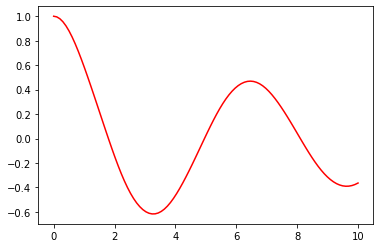

In [30]:
t = np.linspace(0, 10, 100)
u = solution(t, to_numpy=True)  # t can be np.ndarray or torch.Tensor
plt.plot(t,u,color='r')
#plt.plot(t,v,color='b')
plt.show()

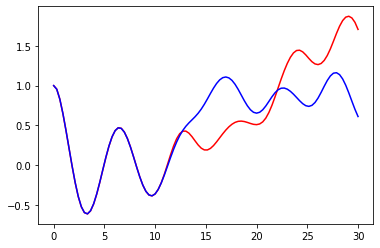

In [20]:
#train 0-10
plt.plot(t,u,color='r')
plt.plot(t,u1,color='b')

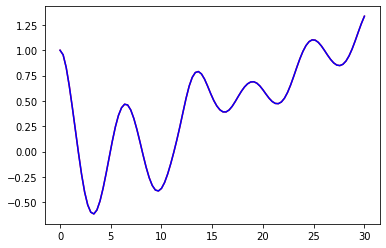

In [34]:
#train 0-10
plt.plot(t,u2,color='r')
plt.plot(t,u3,color='b')

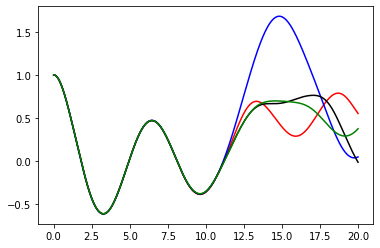

In [13]:
t = np.linspace(0, 20, 1000)
u = solution(t, to_numpy=True)
u1 = solution1(t, to_numpy=True)
u2 = solution2(t, to_numpy=True)
u3 = solution3(t, to_numpy=True)
plt.plot(t,u,color='red')
plt.plot(t,u1,color='blue')
plt.plot(t,u2,color='black')
plt.plot(t,u3,color='green')